# Sentinel: Multi-Agent UAV System with Computer Vision

This notebook implements a sophisticated UAV swarm system with computer vision capabilities for emergency response scenarios.

## Features
* Multi-agent swarm coordination
* Leader-follower dynamics
* Thermal imaging simulation
* Real-time fire detection

## Setup
First, let's import our required libraries:

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors

## 1. Fire Source Simulation
First, we'll implement the fire source simulation that our UAVs will detect:

In [15]:
class FireSource:
    def __init__(self, x, y, intensity=1.0, spread_rate=0.1):
        self.position = np.array([x, y])
        self.intensity = intensity
        self.spread_rate = spread_rate
        self.radius = 20  # Initial fire radius
        
    def update(self):
        # Simulate fire spread
        self.radius += self.spread_rate
        self.intensity = max(0.5, self.intensity * (1 - 0.01 * np.random.random()))

## 2. Thermal Camera System
Next, we implement the thermal camera simulation that will be mounted on each UAV:

In [16]:
class ThermalCamera:
    def __init__(self, resolution=(100, 100), fov=60):
        self.resolution = resolution
        self.fov = fov  # Field of view in degrees
        self.view_distance = 100  # Maximum viewing distance
        
    def capture(self, position, direction, environment):
        thermal_image = np.zeros(self.resolution)
        angle = np.arctan2(direction[1], direction[0])
        
        for fire in environment.fire_sources:
            rel_pos = fire.position - position
            distance = np.linalg.norm(rel_pos)
            
            if distance < self.view_distance:
                rel_angle = np.arctan2(rel_pos[1], rel_pos[0]) - angle
                rel_angle = np.rad2deg(rel_angle)
                
                if abs(rel_angle) < self.fov/2:
                    x_img = int((rel_angle + self.fov/2) / self.fov * self.resolution[0])
                    y_img = int((1 - distance/self.view_distance) * self.resolution[1])
                    intensity = fire.intensity * (1 - distance/self.view_distance)
                    cv2.circle(thermal_image, (x_img, y_img),
                             int(fire.radius * (1 - distance/self.view_distance)),
                             intensity, -1)
        return thermal_image

## 3. Base Drone Implementation
Now we'll implement the base Boid class that provides core swarm behavior:

In [17]:
class Boid:
    def __init__(self, x, y, is_leader=False):
        self.position = np.array([x, y], dtype=float)
        self.velocity = np.array([np.random.randn(), np.random.randn()], dtype=float)
        self.acceleration = np.array([0.0, 0.0])
        self.max_force = 0.5
        self.max_speed = 4.0 if is_leader else 3.0
        self.perception_radius = 50
        self.is_leader = is_leader
        
    def update(self):
        self.velocity += self.acceleration
        speed = np.linalg.norm(self.velocity)
        if speed > self.max_speed:
            self.velocity = (self.velocity / speed) * self.max_speed
        self.position += self.velocity
        self.acceleration = np.array([0.0, 0.0])
        
    def seek(self, target):
        desired = target - self.position
        if np.linalg.norm(desired) > 0:
            desired = desired / np.linalg.norm(desired) * self.max_speed
        steer = desired - self.velocity
        if np.linalg.norm(steer) > self.max_force:
            steer = steer / np.linalg.norm(steer) * self.max_force
        return steer

## 4. CV-Enhanced Drone
Now we extend the Boid class with computer vision capabilities:

In [18]:
class CVDrone(Boid):
    def __init__(self, x, y, is_leader=False):
        super().__init__(x, y, is_leader)
        self.camera = ThermalCamera()
        self.thermal_image = None
        self.detected_fires = []
        
    def process_thermal_image(self, threshold=0.5):
        if self.thermal_image is None:
            return
        
        hot_spots = cv2.threshold(self.thermal_image, threshold, 1, cv2.THRESH_BINARY)[1]
        contours, _ = cv2.findContours(hot_spots.astype(np.uint8),
                                     cv2.RETR_EXTERNAL,
                                     cv2.CHAIN_APPROX_SIMPLE)
        
        self.detected_fires = []
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] > 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                area = cv2.contourArea(contour)
                self.detected_fires.append((cx, cy, area))

## 5. Environment Management
Implementing the environment that will contain and update fire sources:

In [19]:
class Environment:
    def __init__(self):
        self.fire_sources = []
        
    def add_fire(self, x, y):
        self.fire_sources.append(FireSource(x, y))
        
    def update(self):
        for fire in self.fire_sources:
            fire.update()

## 6. Swarm Control System
Implementing the main swarm management system that coordinates all UAVs:

In [20]:
class CVSwarm:
    def __init__(self, num_boids, num_leaders=1):
        self.environment = Environment()
        self.environment.add_fire(300, 200)
        self.environment.add_fire(600, 400)
        
        # Initialize swarm with CV-enabled drones
        self.boids = []
        # Create leaders
        for _ in range(num_leaders):
            x = np.random.randint(0, 800)
            y = np.random.randint(0, 600)
            self.boids.append(CVDrone(x, y, is_leader=True))
        
        # Create followers
        for _ in range(num_boids - num_leaders):
            x = np.random.randint(0, 800)
            y = np.random.randint(0, 600)
            self.boids.append(CVDrone(x, y))

    def cohesion(self, boid):
        """Steer towards average position of nearby boids"""
        steering = np.array([0.0, 0.0])
        total = 0
        
        for other in self.boids:
            distance = np.linalg.norm(other.position - boid.position)
            if other != boid and distance < boid.perception_radius:
                steering += other.position
                total += 1
        
        if total > 0:
            steering = steering / total - boid.position
            if np.linalg.norm(steering) > 0:
                steering = (steering / np.linalg.norm(steering)) * boid.max_speed
            steering = steering - boid.velocity
            if np.linalg.norm(steering) > boid.max_force:
                steering = (steering / np.linalg.norm(steering)) * boid.max_force
        
        return steering

    def alignment(self, boid):
        """Match velocity with nearby boids"""
        steering = np.array([0.0, 0.0])
        total = 0
        
        for other in self.boids:
            distance = np.linalg.norm(other.position - boid.position)
            if other != boid and distance < boid.perception_radius:
                steering += other.velocity
                total += 1
        
        if total > 0:
            steering = steering / total
            if np.linalg.norm(steering) > 0:
                steering = (steering / np.linalg.norm(steering)) * boid.max_speed
            steering = steering - boid.velocity
            if np.linalg.norm(steering) > boid.max_force:
                steering = (steering / np.linalg.norm(steering)) * boid.max_force
        
        return steering

    def separation(self, boid):
        """Avoid crowding nearby boids"""
        steering = np.array([0.0, 0.0])
        total = 0
        
        for other in self.boids:
            distance = np.linalg.norm(other.position - boid.position)
            if other != boid and distance < boid.perception_radius:
                diff = boid.position - other.position
                diff = diff / (distance * distance)  # Weight by distance
                steering += diff
                total += 1
        
        if total > 0:
            steering = steering / total
            if np.linalg.norm(steering) > 0:
                steering = (steering / np.linalg.norm(steering)) * boid.max_speed
            steering = steering - boid.velocity
            if np.linalg.norm(steering) > boid.max_force:
                steering = (steering / np.linalg.norm(steering)) * boid.max_force
        
        return steering
            
    def update_all(self):
        # Update environment
        self.environment.update()
        
        # Update each drone
        for boid in self.boids:
            boid.thermal_image = boid.camera.capture(
                boid.position, 
                boid.velocity, 
                self.environment
            )
            boid.process_thermal_image()
            
            # Update movement based on swarm behavior
            if boid.is_leader:
                # Leaders investigate detected fires
                if boid.detected_fires:
                    # Move towards largest detected fire
                    largest_fire = max(boid.detected_fires, key=lambda x: x[2])
                    target_force = boid.seek(
                        np.array([largest_fire[0], largest_fire[1]])
                    ) * 1.5
                    boid.apply_force(target_force)
            else:
                # Followers maintain swarm behavior
                cohesion = self.cohesion(boid) * 1.0
                alignment = self.alignment(boid) * 1.0
                separation = self.separation(boid) * 1.5
                
                boid.apply_force(cohesion)
                boid.apply_force(alignment)
                boid.apply_force(separation)
            
            # Update position
            boid.update()
            
            # Wrap around screen edges
            boid.position[0] = boid.position[0] % 800
            boid.position[1] = boid.position[1] % 600

## 7. Visualization System
Setting up the visualization and animation system:

In [21]:
def animate(frame):
    plt.clf()
    
    # Set up subplots
    plt.subplot(121)  # Main simulation view
    
    # Draw fire sources
    for fire in swarm.environment.fire_sources:
        circle = plt.Circle(fire.position, fire.radius, 
                          color='red', alpha=fire.intensity)
        plt.gca().add_patch(circle)
    
    # Draw drones
    for boid in swarm.boids:
        if boid.is_leader:
            color = 'blue'
            size = 100
        else:
            color = 'gray'
            size = 50
        plt.scatter(boid.position[0], boid.position[1], c=color, s=size)
        
        # Draw field of view cone
        if isinstance(boid, CVDrone):
            direction = boid.velocity / np.linalg.norm(boid.velocity)
            fov_angle = np.deg2rad(boid.camera.fov/2)
            left_edge = np.array([
                np.cos(np.arctan2(direction[1], direction[0]) - fov_angle),
                np.sin(np.arctan2(direction[1], direction[0]) - fov_angle)
            ])
            right_edge = np.array([
                np.cos(np.arctan2(direction[1], direction[0]) + fov_angle),
                np.sin(np.arctan2(direction[1], direction[0]) + fov_angle)
            ])
            plt.plot([boid.position[0], boid.position[0] + left_edge[0]*50],
                    [boid.position[1], boid.position[1] + left_edge[1]*50],
                    '--', color=color, alpha=0.3)
            plt.plot([boid.position[0], boid.position[0] + right_edge[0]*50],
                    [boid.position[1], boid.position[1] + right_edge[1]*50],
                    '--', color=color, alpha=0.3)
    
    plt.xlim(0, 800)
    plt.ylim(0, 600)
    plt.title('Sentinel: Multi-Agent UAV System')
    
    # Thermal imaging view
    plt.subplot(122)
    if len(swarm.boids) > 0 and swarm.boids[0].thermal_image is not None:
        plt.imshow(swarm.boids[0].thermal_image, cmap='hot')
        plt.title('Thermal Image from Leader Drone')
    
    swarm.update_all()

## 8. Run Simulation
Now let's create and run our simulation:

AttributeError: 'CVDrone' object has no attribute 'apply_force'

Error in callback <function _draw_all_if_interactive at 0x114ce7ac0> (for post_execute), with arguments args (),kwargs {}:


/Users/johnzhu/Desktop/JohnZhu/Sentinel/s1/lib/python3.10/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


AttributeError: 'CVDrone' object has no attribute 'apply_force'

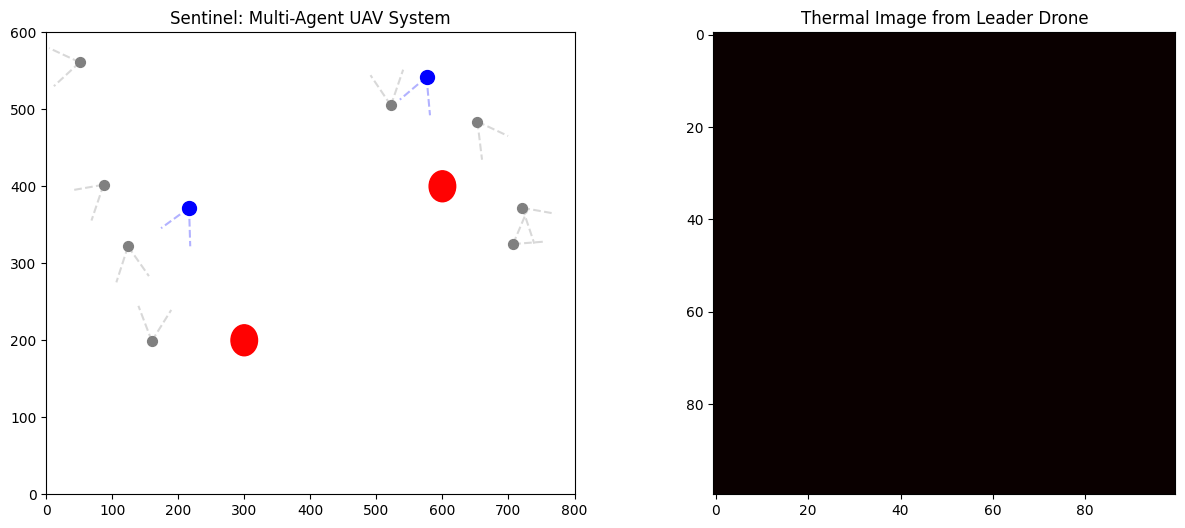

In [22]:
%matplotlib inline

# Create and run simulation
swarm = CVSwarm(num_boids=10, num_leaders=2)
fig = plt.figure(figsize=(15, 6))
anim = FuncAnimation(fig, animate, frames=500, interval=50)

from IPython.display import HTML
HTML(anim.to_jshtml())